#### Data Preprocessing 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"data/LoanData.csv")

# Print shape of dataset
print(df.shape)

(614, 13)


##### Data Cleaning

In [45]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [46]:
df.drop(columns=['Loan_ID'], inplace=True)

In [47]:
df['Loan_Status'] = df['Loan_Status'].replace(('Y', 'N'),(1, 0))

In [48]:
df['Loan_Status'] = df['Loan_Status'].astype('int64')

In [49]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [51]:
# Check null values
features_with_na = [
    features for features in df.columns if df[features].isnull().sum() >= 1
]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean() * 100, 5), "% missing values")

Gender 2.11726 % missing values
Married 0.4886 % missing values
Dependents 2.443 % missing values
Self_Employed 5.21173 % missing values
LoanAmount 3.58306 % missing values
Loan_Amount_Term 2.28013 % missing values
Credit_History 8.14332 % missing values


In [52]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude="object").describe()

,LoanAmount,Loan_Amount_Term,Credit_History
count,592.000000,600.00000,564.000000
mean,146.412162,342.00000,0.842199
std,85.587325,65.12041,0.364878
min,9.000000,12.00000,0.000000
25%,100.000000,360.00000,1.000000
50%,128.000000,360.00000,1.000000
75%,168.000000,360.00000,1.000000
max,700.000000,480.00000,1.000000


In [53]:
# Handling Duplicates
df.duplicated().sum()


0

##### Feature Engineering

In [54]:
# Numeric Features
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]
print("Num of Numerical Features :", len(numeric_features))

Num of Numerical Features : 6


In [55]:
# Categorical Features
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]
print("Num of Categorical Features :", len(categorical_features))
print("All the categorical feature column name:", categorical_features)

Num of Categorical Features : 6
All the categorical feature column name: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [56]:
# Discrete Features
discrete_features = [
    feature for feature in numeric_features if (len(df[feature].unique()) <= 25)
]
print("Num of Discrete Features :", len(discrete_features))
print("All the discrete feature column name:", discrete_features)

Num of Discrete Features : 3
All the discrete feature column name: ['Loan_Amount_Term', 'Credit_History', 'Loan_Status']


In [57]:
# Continuous Features
continuous_features = [
    feature for feature in numeric_features if len(df[feature].unique()) > 25
]
print("Num of Continuous Features :", len(continuous_features))
print("All the continuous feature column name:", continuous_features)

Num of Continuous Features : 3
All the continuous feature column name: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [59]:
df1 = df.copy()
for i in continuous_features:
    df1[i].fillna(df1[i].median(), inplace=True)

#### Multicollinearity Check
##### Variance Inflation Factor (VIF)
- Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
- Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def compute_vif(considered_features, df):

    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [61]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,ApplicantIncome,1.590477
1,CoapplicantIncome,1.122626
2,LoanAmount,1.627108


” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “

VIF above 5 is indicator of MultiCollinearity

- This Dataset Doesnt have any MultiCollinearity

##### Check Outlier and Capping it
Why outliers?

- Data Entry error : Human error.
- Measurement error: Instrument error.
- Natural error: it will be Real life data.
- Intentional error: People give wrong inputs

Impact of Outliers ?

- Ouliers can very high impact on few Machine learning models.
- Can Cause bias in the output.

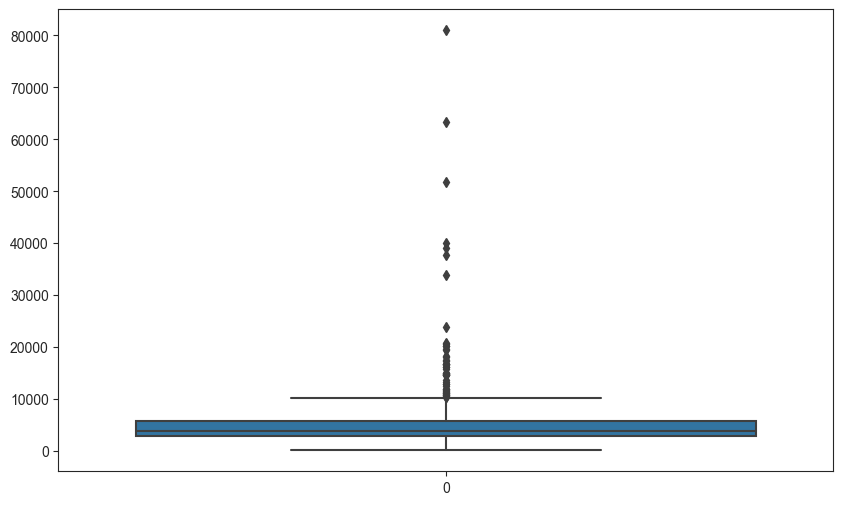

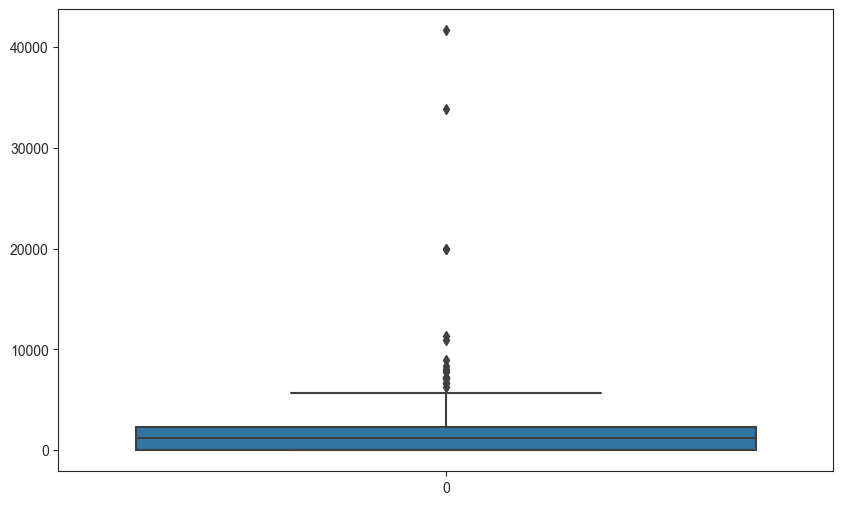

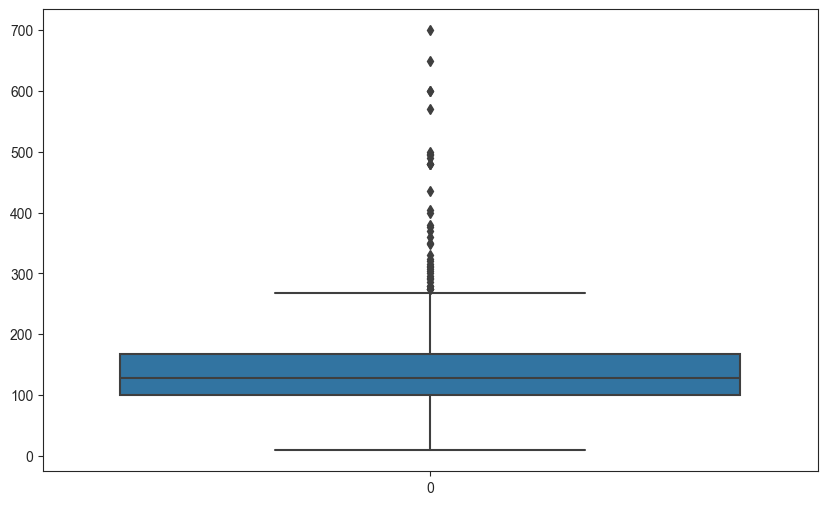

In [62]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

Why standard deviation method For Outlier Handling?

- Outlier removal using standard deviation procedure.
- Usually z-score =3 is considered as a cut-off value to set the limit. Therefore, any z-score greater than +3 or less than -3 is considered as outlier which is pretty much similar to standard deviation method.
- Here we can remove outliers after 3rd standard deviation or z-score +3 and -3. used to remove only extreme outlier points

In [63]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3 * df[column].std()
    lower_limit = df[column].mean() - 3 * df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [64]:
df.shape

(614, 12)

In [65]:
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [66]:
outlier_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [67]:
for i in range(len(outlier_features)):
    df1 = outlier_removal(outlier_features[i], df1)

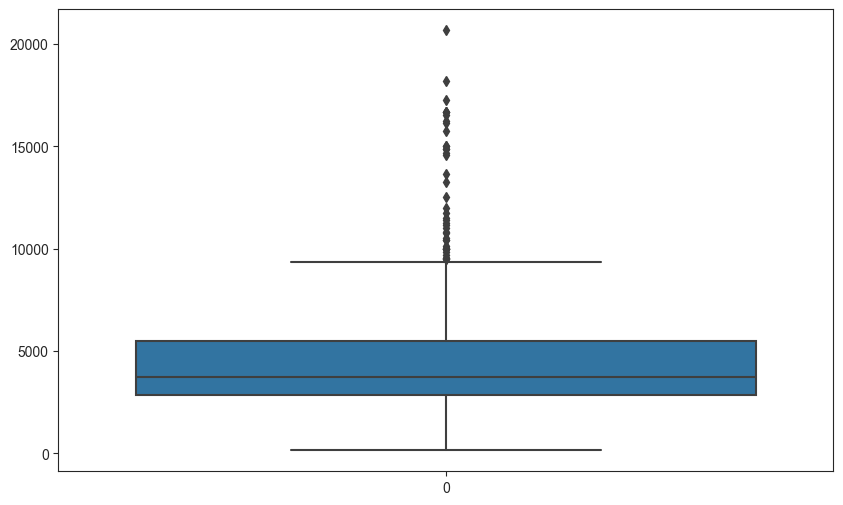

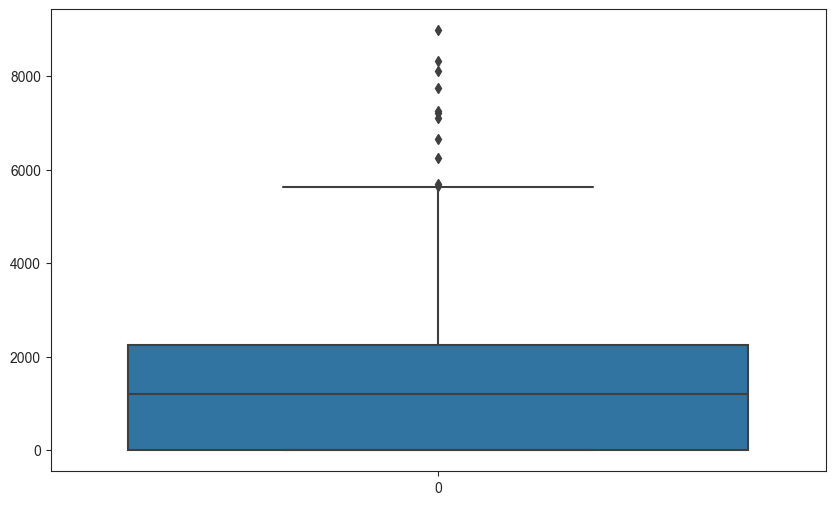

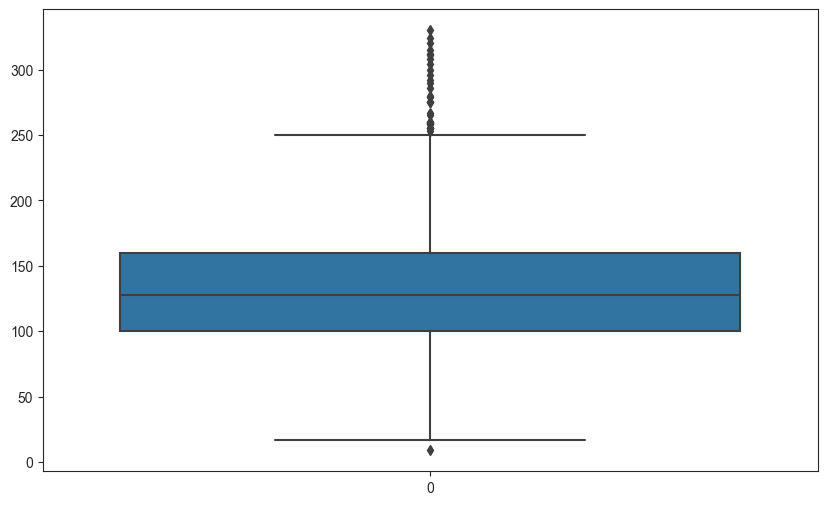

In [68]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df1[i])


##### Feature Transformation

In [69]:
df[continuous_features].skew(axis=0)

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
dtype: float64

- If Skewness is above 2 then the feature is Highly skewed
- If Skewness is above 1.5 then the feature is Moderately skewed

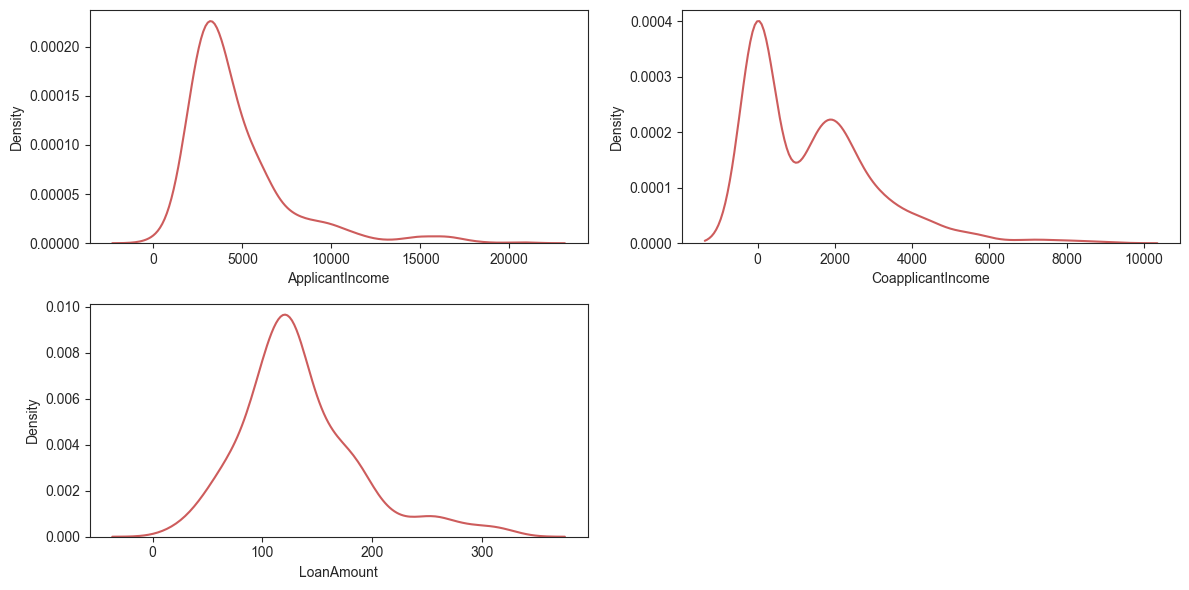

In [70]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(x=df1[col], color="indianred")
    plt.xlabel(col)
    plt.tight_layout()

- Here Monthly ApplicantIncome and CoapplicantIncome are highly skewed.
- But the LoanAmount are little some skewed data are present.

In [71]:
# Split data X and Y

from sklearn.model_selection import train_test_split

X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [72]:
for feature in categorical_features:
    print(feature, ":", X[feature].nunique())

Gender : 2
Married : 2
Dependents : 4
Education : 2
Self_Employed : 2
Property_Area : 3


##### Feature Encoding and Scaling

In [74]:
for i in continuous_features:
    print(f"{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}")

ApplicantIncome: mean = 5403.46, median = 3812.50
CoapplicantIncome: mean = 1621.25, median = 1188.50
LoanAmount: mean = 146.41, median = 128.00


In [75]:
# Create Column Transformer with 3 types of transformers
cat_features = X.select_dtypes(include="object").columns
disc_feature = discrete_features.copy()
disc_feature.remove("Loan_Status")
transform_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]


from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

discrete_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
    ]
)

continuous_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder()),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

transform_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("transformer", PowerTransformer(standardize=True)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("Discrete_Pipeline", discrete_pipeline, disc_feature),
        ("Continuous_Pipeline", continuous_pipeline, continuous_features),
        ("Categorical_Pipeline", cat_pipeline, cat_features),
        ("Power_Transformation", transform_pipe, transform_features),
    ]
)

In [76]:
X.shape

(614, 11)

In [77]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [78]:
X = preprocessor.fit_transform(X)

##### Handling Imbalanced Dataset
- Handling Imbalanced Target Variable.

- Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

- SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

In [81]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority")
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [83]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)  # Calculate Accuracy
    f1 = f1_score(true, predicted)  # Calculate F1-score
    precision = precision_score(true, predicted)  # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted)  # Calculate Roc
    return acc, f1, precision, recall, roc_auc

In [84]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    #"CatBoosting Classifier": CatBoostClassifier(verbose=False),
    #      "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier(),
}

In [85]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    """
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    """
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)  # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        (
            model_train_accuracy,
            model_train_f1,
            model_train_precision,
            model_train_recall,
            model_train_rocauc_score,
        ) = evaluate_clf(y_train, y_train_pred)

        # Test set performance
        (
            model_test_accuracy,
            model_test_f1,
            model_test_precision,
            model_test_recall,
            model_test_rocauc_score,
        ) = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model performance for Training set")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc Auc Score: {:.4f}".format(model_train_rocauc_score))

        print("----------------------------------")

        print("Model performance for Test set")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc Auc Score: {:.4f}".format(model_test_rocauc_score))
        print("=" * 35)
        print("\n")

    report = pd.DataFrame(
        list(zip(models_list, accuracy_list)), columns=["Model Name", "Accuracy"]
    ).sort_values(by=["Accuracy"], ascending=False)

    return report

In [86]:
base_report = evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8625
- F1 score: 0.8625
- Precision: 0.7931
- Recall: 0.9452
- Roc Auc Score: 0.8692


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8125
- F1 score: 0.8077
- Precision: 0.7590
- Recall: 0.8630
- Roc Auc Score: 0.8166


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9279
- F1 score: 0.9335
- Precision: 0.8825
- Recall: 0.9908
- Roc Auc Score: 0.9265
----------------------------------
Model performance for Test set
- Accuracy: 0.7812
- F1 score: 0.7953
- Precision: 0.6939
- Recall: 0.9315
- Roc Auc Score: 0.7933


Logistic Regression
Model performance for Training 

In [87]:
base_report

,Model Name,Accuracy
0,Random Forest,0.86250
5,XGBClassifier,0.84375
1,Decision Tree,0.81250
2,Gradient Boosting,0.78125
6,AdaBoost Classifier,0.78125
3,Logistic Regression,0.72500
4,K-Neighbors Classifier,0.70625


In [88]:
# Initialize few parameter for Hyperparamter tuning
rf_params = {
    "max_depth": [5, 8, 15, None, 10],
    "max_features": [5, 7, "auto", 8],
    "min_samples_split": [2, 8, 15, 20],
    "n_estimators": [100, 200, 500, 1000],
}

xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [5, 8, 12, 20, 30],
    "n_estimators": [100, 200, 300],
    "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4],
}

In [89]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestClassifier(), rf_params),
    ("XGBoost", XGBClassifier(), xgboost_params),
]

In [90]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=100,
        cv=3,
        verbose=2,
        n_jobs=-1,
    )
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for RF -------------------
{'n_estimators': 500, 'min_samples_split': 2, 'max_features': 5, 'max_depth': None}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


Above we can see the best parameters selected for models. It may change when you train because of the random selcetion of parameters by RandomizedSearchCV. But there will ot be much change in the metrics of the models.

##### Retraining the Model with best Parameters
- We can retrain the models with the best parameters selected by the RandomizedSearchCV and check other metrics of the selected models

In [91]:
from sklearn.metrics import roc_auc_score, roc_curve

best_models = {
    "Random Forest": RandomForestClassifier(**model_param["RF"]),
    "XGBClassifier": XGBClassifier(**model_param["XGBoost"], n_jobs=-1),
}
tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8625
- F1 score: 0.8608
- Precision: 0.8000
- Recall: 0.9315
- Roc Auc Score: 0.8681


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8750
- F1 score: 0.8701
- Precision: 0.8272
- Recall: 0.9178
- Roc Auc Score: 0.8784




In [92]:
tuned_report

,Model Name,Accuracy
1,XGBClassifier,0.8750
0,Random Forest,0.8625


Plot Roc Auc Curve
- Now lets check the area under curve(AUC) of receiver operating characteristic(ROC) curve to justify the accuracy we have seen the the selected models.

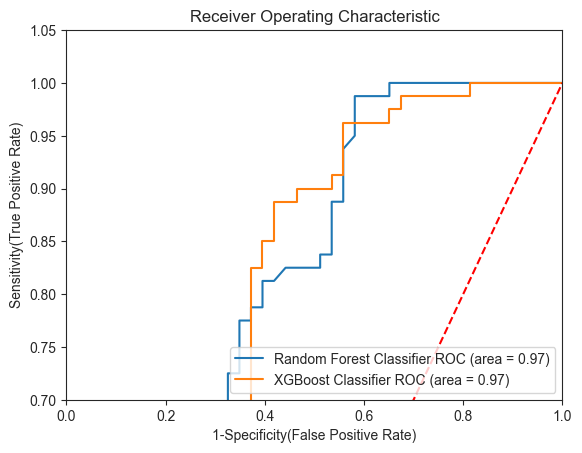

In [93]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
    {
        "label": "Random Forest Classifier",
        "model": RandomForestClassifier(**model_param["RF"]),
        "auc": 0.9692,
    },
    {
        "label": "XGBoost Classifier",
        "model": XGBClassifier(**model_param["XGBoost"]),
        "auc": 0.9710,
    },
]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# create loop through all model
for algo in auc_models:
    model = algo["model"]  # select the model
    model.fit(X_train, y_train)  # train the model
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label="%s ROC (area = %0.2f)" % (algo["label"], algo["auc"]))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.7, 1.05])
plt.xlabel("1-Specificity(False Positive Rate)")
plt.ylabel("Sensitivity(True Positive Rate)")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
# plt.savefig(r"./images/auc.png")
plt.show()  # Display

As Models have very high accuracy we can use cross validation score for further evaluation.
Cross-validation is a statistical method used to estimate the accuracy of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited.

Stratified kfold cross validation is an extension of regular kfold cross validation but specifically for classification problems where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset. Which preserves the distribution of target column in both train and test data.

Stratified K-fold Cross Validation Technique on 3 algorithm to know the exact Mean CV accuracy score

In [94]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [95]:
xgb_cv_result = cross_val_score(
    XGBClassifier(**model_param["XGBoost"]),
    X_test,
    y_test,
    cv=skfold,
    scoring="accuracy",
    n_jobs=-1,
)
xgb_cv = xgb_cv_result.mean() * 100
print("XGB Classifier CV Mean Accuarcy Score is {}".format(xgb_cv))

XGB Classifier CV Mean Accuarcy Score is 69.1025641025641


In [96]:
rf_cv_result = cross_val_score(
    RandomForestClassifier(**model_param["RF"]),
    X_test,
    y_test,
    cv=skfold,
    scoring="accuracy",
    n_jobs=-1,
)
rf_cv = rf_cv_result.mean() * 100
print("Random Forest Classifier CV Mean Accuarcy Score is {}".format(rf_cv))

Random Forest Classifier CV Mean Accuarcy Score is 72.37179487179488


In [99]:
X

array([[ 0.2732313 ,  0.41173269,  0.07299082, ...,  0.5443313 ,
        -1.10283684,  0.23538679],
       [ 0.2732313 ,  0.41173269, -0.13441195, ...,  0.17097382,
         0.75057774, -0.0376586 ],
       [ 0.2732313 ,  0.41173269, -0.39374734, ..., -0.49995512,
        -1.10283684, -1.34630531],
       ...,
       [ 0.2732313 ,  0.41173269,  0.43717437, ...,  1.02348683,
         0.20860307,  1.37240931],
       [ 0.2732313 ,  0.41173269,  0.35706382, ...,  0.93175029,
        -1.10283684,  0.73892362],
       [ 0.2732313 , -2.42876026, -0.13441195, ...,  0.17097382,
        -1.10283684,  0.03993645]])

In [100]:
X_res

array([[ 0.2732313 ,  0.41173269,  0.07299082, ...,  0.5443313 ,
        -1.10283684,  0.23538679],
       [ 0.2732313 ,  0.41173269, -0.13441195, ...,  0.17097382,
         0.75057774, -0.0376586 ],
       [ 0.2732313 ,  0.41173269, -0.39374734, ..., -0.49995512,
        -1.10283684, -1.34630531],
       ...,
       [ 0.2732313 ,  0.36826025, -0.24991563, ..., -0.09048441,
        -1.10283684, -1.44352412],
       [ 0.2732313 ,  0.22265899,  0.73848245, ...,  1.31978418,
        -0.95378553,  0.4764141 ],
       [ 0.2732313 ,  0.41173269,  0.75302947, ...,  1.33353036,
        -0.15860543,  1.07266735]])